In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
import seaborn as sns 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [ ]:
data1=pd.read_csv('Data 1.csv')
data2=pd.read_csv('Data 2.csv')

In [ ]:
#merging the data 
merged_df = pd.merge(data1, data2, on=['event_time', 'event_type', 'product_id', 'category_id',
                                       'category_code', 'brand', 'price', 'user_id', 'user_session'], how='outer')


I have uploaded the merged data so that the entire team can use it simultaneously and free the ram a bit. 

In [ ]:
df=merged_df.copy()


In [ ]:
#there are negative values
df=pd.read_csv('sampled_data.csv')# startified sample from raw data

# EDA

In [ ]:
df.describe()

,product_id,category_id,price,user_id,week
count,8.278272e+06,8.278272e+06,8.278272e+06,8.278272e+06,8.278272e+06
mean,5.472886e+06,1.548164e+18,8.504447e+00,5.046121e+08,4.421702e+01
std,1.318275e+06,1.608680e+17,1.931828e+01,8.385246e+07,2.606602e+00
min,3.752000e+03,1.487580e+18,-7.937000e+01,1.120748e+06,4.000000e+01
25%,5.723502e+06,1.487580e+18,2.050000e+00,4.701307e+08,4.200000e+01
50%,5.809910e+06,1.487580e+18,3.970000e+00,5.413340e+08,4.400000e+01
75%,5.854320e+06,1.487580e+18,6.980000e+00,5.613626e+08,4.700000e+01
max,5.909246e+06,2.195085e+18,3.277800e+02,5.799699e+08,4.800000e+01


s

In [ ]:
display(df)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
...,...,...,...,...,...,...,...,...,...
8738115,2019-11-30 23:59:46 UTC,view,5830317,1487580009496313889,NaN,NaN,4.76,457678989,ee50b160-a4db-4722-8751-6812c5b38295
8738116,2019-11-30 23:59:47 UTC,view,5733064,1487580004832248652,NaN,beautix,9.37,422196217,ab5e6dd5-8700-4ecc-a300-9f1eca5d1a95
8738117,2019-11-30 23:59:47 UTC,view,5867785,1487580007835370453,NaN,kims,31.10,572579084,d42865b7-7e04-4038-9be0-a59165625f06
8738118,2019-11-30 23:59:57 UTC,view,5779406,2151191071051219817,NaN,NaN,2.86,540006764,d4b5aa49-d731-40f1-92f1-277416d6e063


In [ ]:
print(df.info())

From the above we will prioritize data validation and attempt to impute the 'brand'  and then 'category_code' column.

In [ ]:
# dropping the duplicate data for a better performance and more accurate results 
# Print the number of rows in the original DataFrame
print(f"Number of rows in original DataFrame: {len(df)}")
before_dropping=len(df)
# Drop duplicates and print the number of dropped duplicates
df.drop_duplicates(inplace=True)
after_dropping=len(df)
num_dropped = before_dropping - after_dropping
print(f"Number of dropped duplicates: {num_dropped}")

Number of rows in original DataFrame: 8738120
Number of dropped duplicates: 459848


## event_time Column preprocesing and feature engineering 

In [ ]:
# Convert the event_time column to datetime format and extract the date, day of the week, week, and hour
df['event_time'] = pd.to_datetime(df['event_time'])



In [ ]:
df['date'] = df['event_time'].dt.date
df['week'] = df['event_time'].dt.week
df['hour'] = df['event_time'].dt.strftime('%I %p')

<ipython-input-6-7036e5af57f4>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['event_time'].dt.week


In [ ]:
df['day_name'] = df['event_time'].dt.strftime('%A')

In [ ]:
# Extract the day of the week  and day from the event_time column
df['day'] = df['event_time'].dt.dayofweek
df['day'].unique()

array([1, 2, 3, 4, 5, 6, 0])

In [ ]:
# Replace the integer values in the 'day' column with their corresponding string values
# (i.e., 0 -> '1', 1 -> '2', 2 -> '3', ..., 6 -> '7')
df['day'].replace(0,'1',inplace=True)
df['day'].replace(1,'2',inplace=True)
df['day'].replace(2,'3',inplace=True)
df['day'].replace(3,'4',inplace=True)
df['day'].replace(4,'5',inplace=True)
df['day'].replace(5,'6',inplace=True)
df['day'].replace(6,'7',inplace=True)
df['day'].unique()

array(['2', '5', '7', '3', '1', '4', '6'], dtype=object)

## Price Column negative prices handling 

In [ ]:
# Filter the rows where the price is negative and print them
negative_prices = df[df['price'] < 0]
print("Rows with negative prices:")
negative_prices.head()

Rows with negative prices:


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,day_name,purchases_per_user
112860,2019-10-01 19:10:56+00:00,purchase,5716857,1487580014042939619,NaN,NaN,-23.81,552507528,dcdd60c6-1a70-442d-bfb2-0252879054ad,Tuesday,8.0
198302,2019-10-02 08:30:03+00:00,purchase,5716855,1487580014042939619,NaN,NaN,-7.94,550375225,5ddec778-9464-4514-914d-be7b751b8e2c,Wednesday,7.0
436918,2019-10-03 17:37:04+00:00,purchase,5716859,1487580014042939619,NaN,NaN,-47.62,555414763,479149eb-1807-4178-8f6b-87c642350735,Thursday,3.0
443204,2019-10-03 18:25:39+00:00,purchase,5670257,1487580014042939619,NaN,NaN,-15.87,556383221,4333d203-bc4d-4d0d-a6e1-0ea3a97a28c1,Thursday,7.0
1295556,2019-10-09 14:49:14+00:00,purchase,5716855,1487580014042939619,NaN,NaN,-7.94,514562574,fed2aeb4-0c75-44f7-9ca8-1a8be8214779,Wednesday,14.0


In [ ]:
column_counts = negative_prices.count()
column_uniques = negative_prices.nunique()

# Print the count and unique values in each column
print("Count of values in each column:")
print(column_counts)
print("\nUnique values in each column:")
print(column_uniques)

Count of values in each column:
event_time       36
event_type       36
product_id       36
category_id      36
category_code     0
brand             0
price            36
user_id          36
user_session     36
date             36
day              36
week             36
hour             36
day_name         36
dtype: int64

Unique values in each column:
event_time       34
event_type        1
product_id        5
category_id       1
category_code     0
brand             0
price             5
user_id          34
user_session     34
date             27
day               7
week              8
hour             14
day_name          7
dtype: int64


Replacing negative prices for a product with the same product's price if it exists and prints the number of negative prices removed and their percentage out of the total count of prices:

In [ ]:
# Count the number of negative prices and their percentage out of the total count of prices
num_neg_prices = (df['price'] < 0).sum()
pct_neg_prices = num_neg_prices / len(df) * 100
print(f"Number of negative prices: {num_neg_prices} ({pct_neg_prices:.5f}%)")

# Replace negative prices with the same product's price if it exists
neg_products = df.loc[df['price'] < 0, 'product_id'].unique()
for product_id in neg_products:
    same_product_prices = df.loc[(df['product_id'] == product_id) & (df['price'] >= 0), 'price']
    if not same_product_prices.empty:
        new_price = same_product_prices.iloc[0]
        df.loc[(df['product_id'] == product_id) & (df['price'] < 0), 'price'] = new_price

# Count the number of negative prices after replacement and their percentage out of the total count of prices
num_neg_prices_after = (df['price'] < 0).sum()
pct_neg_prices_after = num_neg_prices_after / len(df) * 100
print(f"Number of negative prices after replacement: {num_neg_prices_after} ({pct_neg_prices_after:.5f}%)")

Number of negative prices: 36 (0.00043%)
Number of negative prices after replacement: 36 (0.00043%)


IT is clear that the negative prices won't not impact the analysis, so we will drop them.  

In [ ]:
# Drop the rows with negative values in the 'price' column
df = df.loc[df['price'] >= 0]

## User session column null handling

In [ ]:
nulls_user_session = df[df['user_session'].isnull()] 

In [ ]:
column_counts = nulls_user_session.count()
column_uniques = nulls_user_session.nunique()

# Print the count and unique values in each column
print("Count of values in each column:")
print(column_counts)
print("\nUnique values in each column:")
print(column_uniques)

Count of values in each column:
event_time            1450
event_type            1450
product_id            1450
category_id           1450
category_code           20
brand                  921
price                 1450
user_id               1450
user_session             0
day_name              1450
purchases_per_user     359
dtype: int64

Unique values in each column:
event_time            1303
event_type               3
product_id             827
category_id            179
category_code            4
brand                   87
price                  317
user_id                507
user_session             0
day_name                 7
purchases_per_user      25
dtype: int64


From the above we can say the nulls are missing at random and we can drop them. 

In [ ]:
#dropping 1329 rows in user_session for a clear data
df = df.dropna(subset=['user_session'])

##Data validation 

### First step to ensure integrity and no redundcany we will investiagte  for duplicate and drop them. 

In [ ]:
# dropping the duplicate data for a better performance and more accurate results 
# Print the number of rows in the original DataFrame
#print(f"Number of rows in original DataFrame: {len(df)}")

# Drop duplicates and print the number of dropped duplicates
#df.drop_duplicates(inplace=True)
#num_dropped = len(df) - len(df.drop_duplicates())
#print(f"Number of dropped duplicates: {num_dropped}")

## Brand colum nulls & missing values pattern determination 

### We want to determine whether the product IDs in the 'product_id' column with null values in the 'brand' column have not reappeared with non-null values in the 'brand' column.

In [ ]:
# Create a subset of the data with nulls in the brand column
null_brand = df[df['brand'].isnull()]

# Create a set of unique product IDs with nulls in the brand column
null_brand_ids = set(null_brand['product_id'].unique())

# Create a subset of the data with non-null brand values
non_null_brand = df[df['brand'].notnull()]

# Find the product IDs in null_brand_ids that also appear in the non-null brand subset
matching_ids = [pid for pid in null_brand_ids if pid in non_null_brand['product_id'].unique()]

# sorting data frame by product IDs
matching_ids.sort()

# Print the matching product IDs
for product_id in matching_ids:
    print(f"Product ID {product_id} with null brand occurred again with a non-null brand.")

KeyboardInterrupt: ignored

**We can observe a clear trend where product_ids above 5647110  often reappear with their associated brand. As a result, we can replace the missing values of each product_id with its corresponding brand.**

In [ ]:
# Create a subset of the data with nulls in the brand column
null_brand = df[df['brand'].isnull()]

# Create a set of unique product IDs with nulls in the brand column
null_brand_ids = set(null_brand['product_id'].unique())

# Create a subset of the data with non-null brand values
non_null_brand = df[df['brand'].notnull()]

# Define a function to check if a product ID reappeared with a non-null brand
def check_reappeared_brand(row):
    if row['product_id'] in null_brand_ids and row['brand'] != None:
        return row['brand']
    else:
        return None

# Apply the function to create a new column in df with the reappeared brand information
df['reappeared_brand'] = df.apply(check_reappeared_brand, axis=1)

In [ ]:
df['reappeared_brand'].unique()

KeyError: ignored

In [ ]:
df['reappeared_brand'].value_counts()

jessnail      24361
freedecor     24240
irisk         18919
bpw.style      9607
masura         9136
              ...  
browxenna        12
vilenta          11
kaaral            9
ypsed             5
refectocil        2
Name: reappeared_brand, Length: 75, dtype: int64

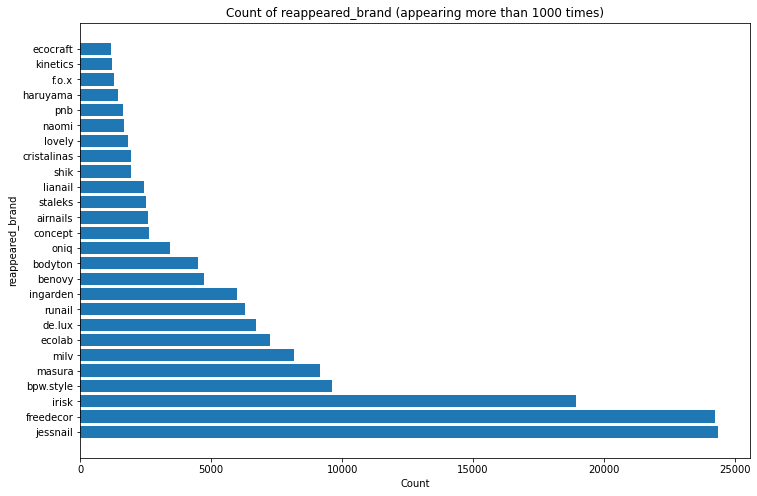

In [ ]:

# Count the number of occurrences of each category
category_counts = df['reappeared_brand'].value_counts()

# Filter categories with fewer than 20 occurrences
category_counts = category_counts[category_counts > 1000]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(category_counts.index, category_counts.values)

# Add labels and title
ax.set_xlabel('Count')
ax.set_ylabel('reappeared_brand')
ax.set_title('Count of reappeared_brand (appearing more than 1000 times)')

# Show the plot
plt.show()

 Graphical representation that shows the count of each instance of the reappeared_brand.


# Filling with reapearing brand
To determine whether the product IDs in the 'product_id' column with null values in the 'brand' column have reappeared with non-null values in the 'brand' column, and then fill the null barnds with the reappeared non-null brand values for the same product_id, you can use the following code:

In [ ]:
df['brand'].isna().sum()

3645290

## for our data the brand missing is Filling with reapearing product_id = 3645290

In [ ]:
# Create a subset of the data with nulls in the brand column
null_brand = df[df['brand'].isnull()]

# Create a set of unique product IDs with nulls in the brand column
null_brand_ids = set(null_brand['product_id'].unique())

# Create a subset of the data with non-null brand values
non_null_brand = df[df['brand'].notnull()]

# Find the product IDs in null_brand_ids that also appear in the non-null brand subset
matching_ids = [pid for pid in null_brand_ids if pid in non_null_brand['product_id'].unique()]


In [ ]:

# Replace the nulls in the brand column with the corresponding non-null values
for product_id in matching_ids:
    non_null_value = non_null_brand.loc[non_null_brand['product_id'] == product_id, 'brand'].iloc[0]
    null_brand.loc[null_brand['product_id'] == product_id, 'brand'] = non_null_value

# Update the original DataFrame with the filled nulls
df.update(null_brand)


In [ ]:
df['brand'].isna().sum()

3636196

In [ ]:
before=3645290
after = 3636196

imputed_from_reapting =before- after
imputed_from_reapting

9094

In [ ]:
# Export the data to a CSV file in Google Drive, to save the ram 
df.to_csv('/content/drive/MyDrive/00-Graduation Project/fill_with_reapted.csv', index=False)

# Product id fomart investigating 

In [ ]:
df['product_id'] = df['product_id'].astype(str) 

checking if all the characters in the product_id column are digits and vary from 3 to 7 digits and have no whitespaces.

In [ ]:
# Check if all product IDs follow the format
is_valid = df['product_id'].astype(str).str.match('^\d{3,7}$', na=False).all()

if is_valid:
    print("All product IDs follow the format of 3 to 7 digits and have no whitespaces.")
else:
    # Filter the DataFrame to include only the product IDs that do not follow the format
    df_invalid = df[~df['product_id'].astype(str).str.match('^\d{3,7}$', na=False)]

    # Get the count and percentage of product IDs that do not follow the format
    count = df_invalid['product_id'].count()
    percentage = count / len(df) * 100

    # Print "No" with the count and percentage of product IDs that do not follow the format
    print(f"No: {count} ({percentage:.2f}%)")

Yes,all product IDs follow the format of 3 to 7 digits and have no whitespaces.


 checking if the product_id is numerical only

In [ ]:
# Check if the product_id column contains only numerical values
is_numerical = df['product_id'].astype(str).str.isnumeric().all()

if is_numerical:
    # Print a message indicating that the product_id column contains only numerical values
    print("The product_id column contains only numerical values.")
else:
    # Print a message indicating that the product_id column contains non-numerical values
    print("The product_id column contains non-numerical values.")

The product_id column contains only numerical values.


Cheking for the distribution of format as their is from 3 to 7 digits format 

In [ ]:
# Create a dictionary to store the count of product IDs for each length
product_id_info = {}

# Get the total count of product IDs
total_count = df['product_id'].nunique()

In [ ]:


# Loop over the possible lengths of product IDs
for length in range(3, 9):
    # Filter the dataframe to include only the product IDs of the current length
    df_length = df[df['product_id'].astype(str).str.len() == length]

    # Get the count and percentage of unique product IDs of the current length
    count = df_length['product_id'].nunique()
    percentage = count / total_count * 100

    # Add the count and percentage to the dictionary
    product_id_info[length] = (count, percentage)


In [ ]:

# Print the counts and percentages for each length
for length, info in product_id_info.items():
    count, percentage = info
    print(f"Product IDs with {length} digits: {count} ({percentage:.2f}%)")

Product IDs with 3 digits: 0 (0.00%)
Product IDs with 4 digits: 904 (1.97%)
Product IDs with 5 digits: 1228 (2.67%)
Product IDs with 6 digits: 0 (0.00%)
Product IDs with 7 digits: 43828 (95.36%)
Product IDs with 8 digits: 0 (0.00%)


This is very intersting as the majority of the format of the product_id is in the 7 digit format, now lets drill down to calculates the percentage of product_id values that are 4, 5, or 7 digits out of the total nulls in the brands column

In [ ]:

# Find the total number of null values in the brands column
null_count = df['brand'].isnull().count()

# Find the number of product_id values that are 4 or 5 digits
matching_count_4or5_digits = ((df['product_id'].astype(str).str.len() == 4) |
                  (df['product_id'].astype(str).str.len() == 5) ).sum()

# Find the number of product_id values that are 7 digits
matching_count_7_digits = ((df['product_id'].astype(str).str.len() == 7)).sum()

# Calculate the percentage of matching product_id values out of the total nulls in brands
percentage_7_digits = matching_count_7_digits / null_count * 100
percentage_4or5_digits= matching_count_4or5_digits / null_count * 100

# Print the percentage of product_id values that are 4 or 5 digits out of the total nulls in brands
print(f"The percentage of product_id values that are 4 or 5 digit out of the total nulls in the brands column is {percentage_4or5_digits:.2f}%.")
# Print the percentage of product_id values that are 7 digits out of the total nulls in brands
print(f"The percentage of product_id values that are 7 digits out of the total nulls in the brands column is {percentage_7_digits:.2f}%.")


The percentage of product_id values that are 4 or 5 digit out of the total nulls in the brands column is 5.46%.
The percentage of product_id values that are 7 digits out of the total nulls in the brands column is 94.54%.


# Product id pattern recognitition 

we first search for pattern for product_id where first three digits repeated exactly. 

to make sure of the result i will do the same code that counts the number of unique product_id that have nulls in brand and but are 7 digits long

First i will try to group product IDs by the exact similarity of their first 3 digit

In [ ]:
# Filter the dataframe to include only the product IDs that are 7 digits long
df_7digits = df[df['product_id'].astype(str).str.len() == 7]

# Group the filtered product IDs by the exact similarity of their first 2 digits
grouped = df_7digits.groupby(df_7digits['product_id'].astype(str).str[:2])

# Iterate over the groups and print the number and percentage of unique product IDs in each group
for name, group in grouped:
    unique_product_ids = group['product_id'].nunique()
    product_ids_not_unique = group['product_id'].count()
    total_product_ids = len(group)


    print(f"Group {name} has {unique_product_ids} unique product IDs, and the total number of product IDs in this group is {total_product_ids} product IDs in the group.")

Group 55 has 1390 unique product IDs, and the total number of product IDs in this group is 391813 product IDs in the group.
Group 56 has 4800 unique product IDs, and the total number of product IDs in this group is 990122 product IDs in the group.
Group 57 has 9280 unique product IDs, and the total number of product IDs in this group is 2043544 product IDs in the group.
Group 58 has 26120 unique product IDs, and the total number of product IDs in this group is 4676110 product IDs in the group.
Group 59 has 2238 unique product IDs, and the total number of product IDs in this group is 159698 product IDs in the group.


we can see that the product_id is starting with 55 and increasing in a very steady pattern till 59

now i want to make sure if the same group of first 4 digits share the same category_id

In [ ]:


# Group the filtered product IDs by the exact similarity of their first 2 digits
grouped_4 = df_7digits.groupby(df_7digits['product_id'].astype(str).str[:5])

# Iterate over the groups and check if they share the same category_id
for name, group in grouped_4:
    # Get the set of unique category IDs in the group
    unique_category_ids = set(group['brand'])
    
    # Check if the set has only one element, meaning all items share the same category_id
    if len(unique_category_ids) == 1:
        print(f"Group {name} has {group['product_id'].nunique()} unique product IDs and shares the same category_id {unique_category_ids.pop()}.")
    else:
        print(f"Group {name} has {group['product_id'].nunique()} unique product IDs and does not share the same category_id.")

Group 55252 has 1 unique product IDs and shares the same category_id depilflax.
Group 55257 has 5 unique product IDs and does not share the same category_id.
Group 55258 has 2 unique product IDs and does not share the same category_id.
Group 55260 has 3 unique product IDs and shares the same category_id ardell.
Group 55272 has 4 unique product IDs and shares the same category_id ardell.
Group 55279 has 13 unique product IDs and shares the same category_id nan.
Group 55280 has 14 unique product IDs and shares the same category_id nan.
Group 55289 has 13 unique product IDs and shares the same category_id nan.
Group 55290 has 4 unique product IDs and shares the same category_id nan.
Group 55291 has 1 unique product IDs and shares the same category_id nan.
Group 55292 has 4 unique product IDs and shares the same category_id orly.
Group 55294 has 4 unique product IDs and does not share the same category_id.
Group 55295 has 3 unique product IDs and shares the same category_id nan.
Group 5530

now i will count the number of product_id values that start with 56, 57, 58, or 59 and consist of 4 or 5 digits, and calculate the percentage of each type of value out of the total count

In [ ]:
# Find the number of product_id values that start with 56, 57, 58, or 59 and consist of 4 or 5 digits
matching_count_4 = ((df['product_id'].astype(str).str.startswith(('55','56' '57', '58', '59'))) &
                   ((df['product_id'].astype(str).str.len() == 4))).sum()

matching_count_5 = ((df['product_id'].astype(str).str.startswith(( '56','57', '58', '59'))) &
                   ((df['product_id'].astype(str).str.len() == 5))).sum()

total_count = matching_count_4 + matching_count_5

# Calculate the percentage of matching 4-digit product_id values out of the total count
percentage_4 = matching_count_4 / total_count * 100

# Calculate the percentage of matching 5-digit product_id values out of the total count
percentage_5 = matching_count_5 / total_count * 100

# Print the number of matching product_id values and their percentage of each length
print(f"There are {matching_count_4} product_id values that start with 56, 57, 58, or 59 and consist of 4 digits, which is {percentage_4:.2f}% of the total matching values.")
print(f"There are {matching_count_5} product_id values that start with 56, 57, 58, or 59 and consist of 5 digits, which is {percentage_5:.2f}% of the total matching values.")

There are 32449 product_id values that start with 56, 57, 58, or 59 and consist of 4 digits, which is 52.56% of the total matching values.
There are 29287 product_id values that start with 56, 57, 58, or 59 and consist of 5 digits, which is 47.44% of the total matching values.


checking if each group of similar first 3 digits share the same brand:

In [ ]:
# Iterate over the groups and check if they share the same brand
for name, group in grouped:
    # Get the set of unique brand values in the group
    unique_brands = set(group['brand'])
    
    # Check if the set has only one element, meaning all items share the same brand
    if len(unique_brands) == 1:
        print(f"Group {name} has {group['product_id'].nunique()} unique product IDs and shares the same brand {unique_brands.pop()}.")
    else:
        print(f"Group {name} has {group['product_id'].nunique()} unique product IDs and does not share the same brand.")

Group 552 has 71 unique product IDs and does not share the same brand.
Group 553 has 40 unique product IDs and does not share the same brand.
Group 554 has 142 unique product IDs and does not share the same brand.
Group 555 has 262 unique product IDs and does not share the same brand.
Group 556 has 423 unique product IDs and does not share the same brand.
Group 557 has 109 unique product IDs and does not share the same brand.
Group 558 has 160 unique product IDs and does not share the same brand.
Group 559 has 183 unique product IDs and does not share the same brand.
Group 560 has 175 unique product IDs and does not share the same brand.
Group 561 has 184 unique product IDs and does not share the same brand.
Group 562 has 182 unique product IDs and does not share the same brand.
Group 563 has 188 unique product IDs and does not share the same brand.
Group 564 has 326 unique product IDs and does not share the same brand.
Group 565 has 603 unique product IDs and does not share the same b

In [ ]:

# Iterate over the groups and print the groups that share the same brand
for name, group in grouped:
    # Get the set of unique brand values in the group
    unique_brands = set(group['brand'])
    
    # Check if the set has only one element, meaning all items share the same brand
    if len(unique_brands) == 1:
        print(f"Group {name} has {group['product_id'].nunique()} unique product IDs and shares the same brand {unique_brands.pop()}.")
    else:
        print("Their is no group that share the same brand.")  

Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is no group that share the same brand.
Their is n

In [ ]:
# Count the number of unique prefix for product IDs
size = grouped.nunique().shape[0]
print(f"There are {size} unique prefix for product IDs in the dataset.")

There are 39 unique prefix for product IDs in the dataset.


In [ ]:
# Count the number of unique product IDs
num_unique_product_ids = df_7digits['product_id'].nunique()
grouped
print(f"There are {num_unique_product_ids} unique product IDs in the dataset.")

There are 43828 unique product IDs in the dataset.


In [ ]:
# Define a regular expression pattern to match the desired pattern
pattern = r'^(\d{3})\w*(\d{3})\2$'

# Find all values in the column that match the regular expression pattern
matches = df['product_id'].astype(str).str.findall(pattern)

# Print the resulting matches
print(matches)

0        []
1        []
2        []
3        []
4        []
         ..
76186    []
76187    []
76188    []
76189    []
76190    []
Name: product_id, Length: 76191, dtype: object

In [ ]:
df['product_id'].isnull().sum()

0

In [ ]:
# Filter the rows where the product_id column starts with zero
filtered_df = df[df['product_id'].astype(str).str.startswith('0')]
filtered_df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
29,2019-10-03 18:05:41 UTC,cart,0090588,1487580007675986893,NaN,NaN,0.76,510369366,f73b666e-fe8d-4cad-b3a2-a3d27ae5aa62
173,2019-10-20 12:52:37 UTC,remove_from_cart,0071778,1495705810704007729,NaN,konad,1.98,516768752,65b864cd-4f81-41c7-b899-2e7f8f1d8621
191,2019-10-28 09:43:22 UTC,cart,0005023,1487580007952810971,NaN,runail,5.00,516768752,07c0197e-a5ba-438b-93a0-50ac78dfda15
193,2019-10-13 17:30:21 UTC,cart,0006186,1487580011098538083,NaN,runail,0.79,516768752,3c335669-a809-4955-a5ba-f1338ed02cb7
196,2019-10-20 22:43:59 UTC,view,0006186,1487580011098538083,NaN,runail,0.79,516768752,b9586987-9147-01a7-5f67-5b54ccf11788
...,...,...,...,...,...,...,...,...,...
76151,2019-10-16 20:44:03 UTC,view,0008098,1487580006350586771,appliances.environment.vacuum,NaN,1.11,560506699,f6b57cce-6482-49d8-a2b2-fd0d05e30e9e
76154,2019-10-04 13:43:44 UTC,view,0006949,1487580006895846315,NaN,runail,3.57,395791933,bf96c5bb-41a0-4679-982b-7b57a185578d
76165,2019-10-04 04:35:36 UTC,view,0005526,1487580006199591819,NaN,ingarden,5.24,495489964,e54fbcf0-c5d4-4077-a51b-ee5d9550f3d9
76167,2019-10-26 18:31:52 UTC,cart,0019162,1487580008447738866,NaN,cnd,10.29,564469904,ab955706-e501-45ae-b1ca-4f64e260ab9e


In [ ]:
# Extract the first 3 digits of each value in the column
df['first_3_digits'] = df['product_id'].astype(str).str[:3]

# Identify the unique values of the first 3 digits
unique_first_3_digits = sorted(df['first_3_digits'].unique())

# Loop through each unique first 3 digits value
for digits in unique_first_3_digits:
    # Create a regular expression pattern to match missing digits
    pattern = digits + r'\d{0,4}'
    missing_values = df[~df['product_id'].astype(str).str.contains(pattern)]['product_id']
    if not missing_values.empty:
        print(f"Missing values for first 3 digits {digits}:")
        print(missing_values)

Missing values for first 3 digits 100:
0        5772465
1        5788141
2        5843552
3        5822993
4        5809906
          ...   
76186    5677462
76187    5713405
76188    5868478
76189    5841297
76190    5740986
Name: product_id, Length: 75979, dtype: int64
Missing values for first 3 digits 101:
0        5772465
1        5788141
2        5843552
3        5822993
4        5809906
          ...   
76186    5677462
76187    5713405
76188    5868478
76189    5841297
76190    5740986
Name: product_id, Length: 75867, dtype: int64
Missing values for first 3 digits 102:
0        5772465
1        5788141
2        5843552
3        5822993
4        5809906
          ...   
76186    5677462
76187    5713405
76188    5868478
76189    5841297
76190    5740986
Name: product_id, Length: 76002, dtype: int64
Missing values for first 3 digits 110:
0        5772465
1        5788141
2        5843552
3        5822993
4        5809906
          ...   
76186    5677462
76187    5713405
76188    

# below 580000 product_id 

In [ ]:
filtered_df = df[df['product_id'] < 5800000]

NameError: ignored

# Group by category id

In [ ]:
 count_starting_with_555 = df[df['product_id'].str.startswith('555')]
 count_starting_with_555

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
230,2019-10-28 21:55:59 UTC,remove_from_cart,5550824,1487580009496313889,NaN,xxxxxx,6.83,494539592,e85470da-b56e-4c02-a0cd-456bc7922003
269,2019-10-28 21:55:59 UTC,remove_from_cart,5550824,1487580009496313889,NaN,xxxxxx,6.83,494539592,e85470da-b56e-4c02-a0cd-456bc7922003
859,2019-10-22 16:09:57 UTC,view,5550686,1487580008145748965,NaN,xxxxxx,1.11,475333301,2e1e5838-4b5e-4089-8488-d79e5d772705
870,2019-10-08 18:49:14 UTC,view,5555860,1487580007675986893,NaN,xxxxxx,0.54,475333301,762b8754-0299-a80a-a9a6-10660b5c3439
883,2019-10-22 16:09:57 UTC,view,5550686,1487580008145748965,NaN,xxxxxx,1.11,475333301,2e1e5838-4b5e-4089-8488-d79e5d772705
...,...,...,...,...,...,...,...,...,...
74630,2019-10-08 03:54:48 UTC,view,5557758,1487580005528503146,NaN,pnb,5.24,534664348,8aee56a2-d9e9-4c73-8ee4-0b4eed70c29a
74981,2019-10-29 11:33:17 UTC,cart,5550302,2195085255034011676,NaN,xxxxxx,1.21,425781472,fe9317d6-b7b2-4cf8-aaed-16d32b1ee505
74995,2019-10-09 18:03:44 UTC,view,5550700,1487580008145748965,NaN,xxxxxx,5.40,517141418,4b73fbc1-1b1f-4cd2-96c8-46df51b88614
75674,2019-10-21 13:55:18 UTC,cart,5558316,1487580005092295511,NaN,pnb,5.24,562620240,ee865476-14c4-4220-9820-89d5d9e83caa


In [ ]:
# Count the number of product_id values that start with 5
count_starting_with_555 = df[df['product_id'].str.startswith('555')]['product_id'].count()

# Calculate the total count of product_id values
total_count = df['product_id'].count()

# Calculate the percentage of product_id values that start with 5
percentage_starting_with_555 = count_starting_with_5 / total_count * 100

# Print the resulting percentage
print(f"{percentage_starting_with_5:.2f}%")

96.25%


In [ ]:

# Filter the DataFrame to include only rows where the 'product_id' value doesn't start with 5
not_start_with_5 = df[~df['product_id'].str.startswith('5')]
not_start_with_5

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
29,2019-10-03 18:05:41 UTC,cart,90588,1487580007675986893,NaN,xxxxxx,0.76,510369366,f73b666e-fe8d-4cad-b3a2-a3d27ae5aa62
173,2019-10-20 12:52:37 UTC,remove_from_cart,71778,1495705810704007729,NaN,konad,1.98,516768752,65b864cd-4f81-41c7-b899-2e7f8f1d8621
193,2019-10-13 17:30:21 UTC,cart,6186,1487580011098538083,NaN,runail,0.79,516768752,3c335669-a809-4955-a5ba-f1338ed02cb7
196,2019-10-20 22:43:59 UTC,view,6186,1487580011098538083,NaN,runail,0.79,516768752,b9586987-9147-01a7-5f67-5b54ccf11788
197,2019-10-24 11:53:17 UTC,view,4961,1487580008145748965,NaN,runail,2.70,516768752,a8f7b829-408e-4895-a14f-8ea3c8213d0d
...,...,...,...,...,...,...,...,...,...
76146,2019-10-02 17:47:58 UTC,cart,35344,1487580012717539489,NaN,xxxxxx,0.56,444149549,30f90d15-6133-4263-955b-c0dae9cb6e6e
76151,2019-10-16 20:44:03 UTC,view,8098,1487580006350586771,appliances.environment.vacuum,xxxxxx,1.11,560506699,f6b57cce-6482-49d8-a2b2-fd0d05e30e9e
76154,2019-10-04 13:43:44 UTC,view,6949,1487580006895846315,NaN,runail,3.57,395791933,bf96c5bb-41a0-4679-982b-7b57a185578d
76167,2019-10-26 18:31:52 UTC,cart,19162,1487580008447738866,NaN,cnd,10.29,564469904,ab955706-e501-45ae-b1ca-4f64e260ab9e


**we can conculde that product_id normaly start with 5 **

In [ ]:
grouped_df.isna().sum()

category_id    0
product_id     0
brand          0
count          0
dtype: int64

# Figuring out the pattern in product id

In [ ]:
print(df.isnull().sum())


event_time             0
event_type             0
product_id             0
category_id            0
category_code    8594895
brand            3636196
price                  0
user_id                0
user_session        1450
dtype: int64


In [ ]:
print(df.nunique())


## We can clearly see that the number of brand is less than than the number of  category_id 

The reason can be one of the folllowing:

> 1. Some products may not have a specific brand assigned to them. For example, a generic or unbranded product may be included in a specific category. In this case, the unique count of brands would be lower than the number of category IDs.

> 2. Some products may have been discontinued or are no longer offered by the business, which would result in a lower unique count of brands.


In [ ]:
display(train_data.head())

## Now we want to measure how much the stratified sample is representative for the population 

In [ ]:
display(grouped)

Now we need to delete teh df to free the ram

In [ ]:
import gc
del train_data 

gc.collect()

In [ ]:

# Extract the first 3 digits of each value in the column
df['first_3_digits'] = df['product_id'].astype(str).str[:3]

# Identify the unique values of the first 3 digits
unique_first_3_digits = sorted(df['first_3_digits'].unique())

# Loop through each unique first 3 digits value
for digits in unique_first_3_digits:
    # Create a regular expression pattern to match missing digits
    pattern = digits + r'\d{0,4}'
    missing_values = df[~df['product_id'].astype(str).str.contains(pattern)]['product_id']
    if not missing_values.empty:
        print(f"Missing values for first 3 digits {digits}:")
        print(missing_values)

we need to change the type of the column event_type to date time first so the model can deal with it 

In [ ]:

# Convert the 'event_type' column to datetime
df_s['event_time'] = pd.to_datetime(df_s['event_time'])



---



In [ ]:
# df_s['event_time'] = pd.to_datetime(df_s['event_time']).dt.tz_localize(None)
df_s['event_time'] = pd.to_datetime(df_s['event_time']).dt.tz_localize(None)


In [ ]:
df_s['product_id']= df_s['product_id'].astype('str')


In [ ]:

# Split the data into training and testing sets with an 80/20 split
X = df_s.drop(['product_id','event_time' ],       axis=1)
y = df_s['product_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  

print('Data types of x DataFrame:')
print(X.dtypes)

# Print the data types of the columns in 'y' DataFrame
print('\nData types of y DataFrame:')
print(y.dtypes)

In [ ]:

# Fit a Random Forest classifier to the training data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Use cross-validation to evaluate the performance of the model
cv_scores = cross_val_score(clf, X, y, cv=5)

# Print the cross-validation scores
print('Cross-validation scores:', cv_scores)

# Use the trained model to predict the format integrity of the product IDs in the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model on the test set
accuracy = (y_pred == y_test).mean()
print('Accuracy on test set:', accuracy)

#Data analysis

##Interaction time (Event_type column)

In [ ]:
# create a copy of the dataframe and rename it to df_journey
df_journey  = df.copy()

In [ ]:
df_journey['event_time'] = pd.to_datetime(df_journey['event_time'])

In [ ]:

# group the rows by user_id, product_id, and user_session
grouped = df_journey.groupby(['user_id', 'product_id', 'user_session'])


In [ ]:
# create a new column to indicate the start of a journey
df_journey['journey_start'] = df_journey['event_type'].groupby([df_journey['user_id'], df_journey['product_id']]).cumsum().astype(bool)

# create a new column to indicate the end of a journey
df_journey['journey_end'] = df_journey['event_type'].eq('purchase').groupby([df_journey['user_id'], df_journey['product_id']]).cumsum().astype(bool)

TypeError: ignored

In [ ]:
# create a new column to calculate the interaction time for each product
df_journey['interactionTime'] = grouped['event_time'].transform(lambda x: (x.max() - x.min()).seconds)

In [ ]:
df_journey['interactionTime'].value_counts()

0.0       74850
1.0          84
2.0          37
3.0          20
6.0          18
          ...  
2453.0        2
325.0         2
4407.0        2
1994.0        2
639.0         2
Name: interactionTime, Length: 446, dtype: int64

In [ ]:
interactions_per_user = df_journey.groupby('user_id')['interactionTime'].mean()

In [ ]:
interactions_per_user

user_id
8846226      0.0
10280338     0.0
14297993     0.0
20554973     0.0
25893719     0.0
            ... 
566268788    0.0
566269562    0.0
566270279    0.0
566272508    0.0
566272734    0.0
Name: interactionTime, Length: 37205, dtype: float64

In [ ]:
# this snippet measure user interaction with paltofrom as whole
df_journey['event_time'] = pd.to_datetime(df_journey['event_time'])

grouped = df_journey.groupby(['user_id', 'user_session'])

# create a new column to calculate the interaction time for each journey
df_journey['interactionTime'] = grouped['event_time'].transform(lambda x: (x.max() - x.min()).seconds)

df_journey['interactionTime'].value_counts()

0.0        46764
1.0          113
2.0          108
4.0           88
8.0           80
           ...  
936.0          2
15917.0        2
2104.0         2
40432.0        2
3937.0         2
Name: interactionTime, Length: 4588, dtype: int64

#### Event_type distribution 

In [ ]:
# Filter the data to only include 'purchase' events
purchases = df[df['event_type'] == 'purchase']

# Group the data by user_id and count the number of purchases
purchases_per_user = purchases.groupby('user_id')['event_type'].count()

df['purchases_per_user'] = df['user_id'].map(purchases_per_user)

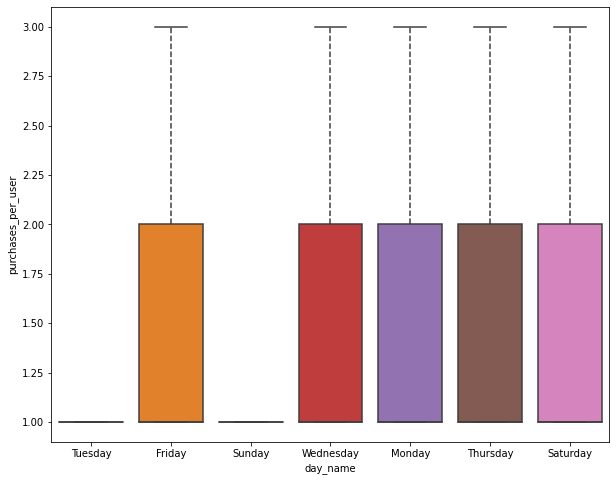

In [ ]:
# Plot the box plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='day_name', y='purchases_per_user', data=df,showfliers=False, whiskerprops={'linestyle': '--'})


# Display the plot
plt.show()

From the figure we can say that the purchase has no trend among days of week 

#### Repurchase Rate

In [ ]:


# Add a 'month' column to the DataFrame
df['month'] = df['event_time'].dt.to_period('M')

# Filter the DataFrame to only include purchase events
df_purchase = df.loc[df['event_type'] == 'purchase']

# Group the rows by user_id, user_session, and month, and sum the revenue for each group
revenue_per_session = df_purchase.groupby(['user_id', 'user_session', 'month'])['price'].sum().reset_index()

# Group the rows by user_id, month, and count the number of unique user_sessions for each group
sessions_per_user = df_purchase.groupby(['user_id', 'month'])['user_session'].nunique().reset_index()

# Merge the revenue_per_session and sessions_per_user DataFrames on the 'user_id' and 'month' columns
revenue_and_sessions = pd.merge(revenue_per_session, sessions_per_user, on=['user_id', 'month'])

# Filter the rows where the user has more than one session
revenue_per_repeat_session = revenue_and_sessions.loc[revenue_and_sessions['user_session_y'] > 1]

# Convert the 'month' column to a DatetimeIndex to avoid a Grouper error
revenue_per_repeat_session['month'] = pd.to_datetime(revenue_per_repeat_session['month'].astype(str))

# Group the repeat sessions by month and calculate the total revenue from repeat sessions for each month
monthly_revenue = revenue_per_repeat_session.groupby(pd.Grouper(key='month', freq='M'))['price'].sum().tz_localize(None)

# Group the purchase events by month and count the number of unique users for each month
monthly_users = df_purchase.groupby(pd.Grouper(key='event_time', freq='M'))['user_id'].nunique().tz_localize(None)

# Calculate the repeat purchase rate for each month
monthly_repeat_purchase_rate = monthly_revenue / monthly_users

# Calculate the overall repeat purchase rate
overall_revenue = revenue_per_repeat_session['price'].sum()
overall_users = df_purchase['user_id'].nunique()
overall_repeat_purchase_rate = overall_revenue / overall_users

# Print the monthly and overall repeat purchase rates
print(f"Monthly Repeat Purchase Rates:{monthly_repeat_purchase_rate}")

print(f"\nOverall Repeat Purchase Rate:{overall_repeat_purchase_rate}")



Monthly Repeat Purchase Rates:month
2019-10-31    11.029571
2019-11-30    13.057024
Freq: M, dtype: float64

Overall Repeat Purchase Rate:13.246643565675988


How to Improve Retention Rate and Repurchase Rate:
Here are 8 ideas for increasing your retention rate and repurchase rate:<br>
1- Personalized user expeirnce  Using the recommendation system and assosiaition rules <br>
2- Loyalty Programs:explain the benifits of company's Loyalty Programs for customers with low  Repurchase Rate.<br>
3- Subscription Model: with coupons and free delivery or express delivery for subscriped customers. 

### Avg customer cart per session 

In [ ]:
# filter the dataframe to only include cart events 
df_cart = df.loc[df['event_type'] == 'cart']

# group the rows by user_id and user_session and count the number of cart events for each session
grouped = df_cart.groupby(['user_id','user_session'])
num_cart_events = grouped.size()

# calculate the average number of cart events per session for each user
avg_num_cart_events = num_cart_events.groupby('user_id').mean()

# display the result
print(avg_num_cart_events)

user_id
8846226      1.0
10280338     1.0
25893719     1.0
28039172     1.0
29025780     1.0
            ... 
566259752    2.0
566264977    1.0
566264992    2.0
566269562    1.0
566272508    1.0
Length: 16591, dtype: float64


In [ ]:
# group the rows by user_id and user_session and count the number of cart events for each session
grouped = df_cart.groupby(['user_id','user_session'])
num_cart_events = grouped.size()

# calculate the average number of cart events per session for all users
avg_num_cart_events = num_cart_events.mean()

# display the result
print(f'The average number of cart events per session for all users is {avg_num_cart_events:.2f}.')

The average number of cart events per session for all users is 5.66.


In [ ]:
# filter the dataframe to only include purchase events 
df_purchase = df.loc[df['event_type'] == 'purchase']

# group the rows by user_id and user_session and count the number of purchase events for each session
grouped = df_purchase.groupby(['user_id','user_session'])
num_purchase_events = grouped.size()

# calculate the average number of purchase events per session for all users
avg_num_purchase_events = num_purchase_events.mean()

# display the result
print(f'The average number of purchase events per session for all users is {avg_num_purchase_events:.2f}.')

The average number of purchase events per session for all users is 8.64.


In [ ]:
# filter the dataframe to only include remove_from_cart events 
df_remove = df.loc[df['event_type'] == 'remove_from_cart']

# group the rows by user_id and user_session and count the number of remove_from_cart events for each session
grouped = df_remove.groupby(['user_id','user_session'])
num_remove_events = grouped.size()

# calculate the average number of remove_from_cart events per session for all users
avg_num_remove_events = num_remove_events.mean()

# display the result
print(f'The average number of remove_from_cart events per session for all users is {avg_num_remove_events:.2f}.')

The average number of remove_from_cart events per session for all users is 6.29.


In [ ]:
# filter the dataframe to only include view events 
df_view = df.loc[df['event_type'] == 'view']

# group the rows by user_id and user_session and count the number of view events for each session
grouped = df_view.groupby(['user_id','user_session'])
num_view_events = grouped.size()

# calculate the average number of view events per session for all users
avg_num_view_events = num_view_events.mean()

# display the result
print(f'The average number of view events per session for all users is {avg_num_view_events:.2f}.')

The average number of view events per session for all users is 2.31.


In [ ]:
# group the rows by event_type and count the number of events for each type
grouped = df.groupby('event_type')
num_events = grouped.size()

# display the result
print(num_events)

event_type
cart                2493850
purchase             567550
remove_from_cart    1278829
view                3938043
dtype: int64


In [ ]:
# count the number of unique customers
num_customers = df['user_id'].nunique()

# display the result
print(f'The number of unique customers is {num_customers}.')

The number of unique customers is 713100.


Now i will count the number of customer that make 80 % of purchase event_type according to parito rule.

In [ ]:

# filter the dataframe to only include events of the desired type
df_event = df.loc[df['event_type'] == 'purchase']

# count the number of unique customers
num_customers = df['user_id'].nunique()

# group the rows by user_id and sum the revenue for each user
revenue_per_user = df_event.groupby('user_id')['price'].sum()

# sort the revenue_per_user series in descending order
sorted_revenue = revenue_per_user.sort_values(ascending=False)

# calculate the cumulative sum of revenue
cumulative_revenue = sorted_revenue.cumsum()

# calculate the total revenue and the 80% threshold
total_revenue = sorted_revenue.sum()
threshold = 0.8 * total_revenue

# count the number of users needed to reach the 80% threshold
num_top_users = (cumulative_revenue <= threshold).sum()

# calculate the percentage of customers who make 80% of the purchases for the desired event type relative to the total number of customers
percent_top_users = (num_top_users / num_customers) * 100

# display the result
print(f'{num_top_users} customers out of {num_customers} customer make 80% of the {df_event.shape[0]} purchases for the {df_event.iloc[0]["event_type"]} event, which represents {percent_top_users:.2f}% of all customers.')

23940 customers out of 713100 make 80% of the 567550 purchases for the purchase event, which represents 3.36% of all customers.


**We recommend providing a special loyalty program for that segment of customers.**

###Average number of sessions per user

In [ ]:
# Group the data by user_id and count the number of unique sessions for each user
sessions_per_user = df.groupby('user_id')['user_session'].nunique()

# Calculate the average number of sessions per user
avg_sessions_per_user = sessions_per_user.mean()

# Display the result
print(f"Average number of sessions per user: {avg_sessions_per_user}")

Average number of sessions per user: 1.5303588227388791


### Bounce rate 

In [ ]:

# Create a boolean mask for sessions where the user only viewed a single product
viewed_one_product_mask = df.groupby(['user_id', 'user_session', 'product_id'])['event_type'].nunique() == 1

# Create a boolean mask for sessions where the user viewed a product but did not add it to their cart or make a purchase
viewed_and_left_mask = df[df['event_type'] == 'view'].groupby(['user_id', 'user_session', 'product_id'])[['event_type']].count() == 1
viewed_and_left_mask = viewed_and_left_mask & df[df['event_type'] == 'view'][['user_id', 'user_session', 'product_id']].drop_duplicates().set_index(['user_id', 'user_session', 'product_id'])

# Reset the index of both masks
viewed_one_product_mask = viewed_one_product_mask.reset_index()
viewed_and_left_mask = viewed_and_left_mask.reset_index()

# Apply the masks to the DataFrame to get the bounce rate for each user
sessions_with_bounce = viewed_one_product_mask.merge(viewed_and_left_mask, on=['user_id', 'user_session', 'product_id'], how='inner')
bounce_rate = sessions_with_bounce.groupby('user_id').size() / df.groupby('user_id')['user_session'].nunique()

# Calculate the average bounce rate of all customers
average_bounce_rate = bounce_rate.mean()

# Display the results
print(f"Bounce rate by user:\n{bounce_rate}")
print(f"Average bounce rate of all customers: {average_bounce_rate}")


Bounce rate by user:
user_id
8846226      NaN
10280338     NaN
14297993     1.0
20554973     1.0
25893719     0.5
            ... 
566268788    1.0
566269562    NaN
566270279    NaN
566272508    NaN
566272734    NaN
Length: 37205, dtype: float64
Average bounce rate of all customers: 0.948579127406141
